# Diffractive Autoencoder for MNIST classification task

This notebook is based on the article <span style="color:orange">"All-optical autoencoder machine learning framework using diffractive processors"</span> [[1]](https://arxiv.org/pdf/2409.20346).

### Imports

In [1]:
import os
import sys
import random

In [2]:
import time
import json

In [3]:
# import warnings
# warnings.simplefilter("always")  # always show warnings!

In [4]:
import numpy as np

In [5]:
from collections import Counter

In [6]:
import torch
from torch.utils.data import Dataset

In [7]:
from torch import nn

In [8]:
from torch.nn import functional

In [9]:
import torchvision
import torchvision.transforms as transforms

In [10]:
from torchvision.transforms import InterpolationMode

In [11]:
# our library
from svetlanna import SimulationParameters
from svetlanna.parameters import ConstrainedParameter

In [12]:
# our library
from svetlanna import Wavefront
from svetlanna import elements
from svetlanna.detector import Detector, DetectorProcessorClf

In [13]:
from svetlanna.transforms import ToWavefront

In [14]:
# dataset
from src.wf_datasets import DatasetOfWavefronts

In [15]:
from tqdm import tqdm

In [16]:
from datetime import datetime

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('dark_background')
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

In [18]:
today_date = datetime.today().strftime('%d-%m-%Y_%H-%M')  # date for a results folder name
today_date

'26-03-2025_23-38'

In [19]:
# Define all necessery variables for that notebook
VARIABLES = {
    # FILEPATHES
    'data_path': './data',  # folder which will be created (if not exists) to load/store Weizmann dataset
    'results_path': f'models/autoencoder/ae_exp_{today_date}',  # filepath to save results!
    
    # GENERAL SETTINGS - SECTION 1 of the notebook
    'wavelength': 0.435 * 1e-3,  # working wavelength, in [m]
        # Comment: Value from the article [1] - 0.435 * 1e-3  # in [m]
    'neuron_size': 0.435 * 1e-3,  # size of a pixel for DiffractiveLayers, in [m]
        # Comment: Value from the article [1] - 64 neurons ~ 27.84 * 1e-3  # in [m]
    'mesh_size': (160, 160),  # full size of a layer = numerical mesh
        # Comment: value from the article [1] - (160, 160)

    'use_apertures': False,  # if we need to add apertures before each Diffractie layer
        # Comment: value from the article [1] - unknown
    'aperture_size': (64, 64),  # size of each aperture = a detector square for classes zones
        # Comment: value from the article [1] - unknown
    
    # DATASET OF SUBSEQUENCES SETTINGS - SECTION 2 of the notebook
    'resize': (64, 64),  # size to resize pictures to add 0th padding then (up to the mesh size)
    'modulation': 'amp',  # modulation type to make a wavefront from each picture mask (see 2.3.2.)
        # Comment: can be equal to `phase`, `amp` or `both`

    # NETWORK - SECTION 3 of the notebook
    'max_phase': 2 * torch.pi,  # maximal possible phase for each DiffractiveLayer
    'free_space_method': 'AS',  # propagation method
        # Comment: can be 'AS' or 'fresnel'
    'distance': 34.8 * 1e-3,  # distance between diffractive layers 
        # Comment: distances between two successive layers were all 34.8mm (80 * wavelength)

    # ENCODER
    'encoder_use_slm': True,  # use SLM (if True) or DiffractiveLayers (if False)
    'encoder_num_layers': 5,
    'encoder_init_phases': torch.pi,
    # value or a list of initial constant phases for DiffractiveLayers OR SLM
    # SLM settings - if 'use_slm' == True
        # Comment: a size of each SLM is equal to SimulationParameters!
    'encoder_slm_shapes': [(160, 160), (160, 160), (80, 80), (80, 80), (40, 40)],
        # list of size 'encoder_num_layers'
    'encoder_slm_levels': 256, 
        # value OR a list (len = 'encoder_num_layers') of numbers of levels for each SLM
    'encoder_slm_step_funcs': 'linear',  # value OR a list of step function names
        # Comment: available stp functions names - 'linear'

    # PRESERVE PHASE OR NOT?!
    'preserve_phase': False,  # by default - resets phases after encoding (before decoding)

    # DECODER - same params!
    'decoder_use_slm': False,
    'decoder_num_layers': 5,
    'decoder_init_phases': torch.pi,
    # SLM settings - if 'use_slm' == True
    'decoder_slm_shapes': (160, 160),
    'decoder_slm_levels': 256, 
    'decoder_slm_step_funcs': 'linear',

    # NETWORK LEARNING - SECTION 4 of the notebook
    # FOR CUSTOM LOSS
    'eta_th': 0.04,  # value for loss (see 4.1.2.)
    'encoding_region_size': (20, 20),  # a shape of encoding image
        # Comment: value from the article [1] - (8, 8)
    'gamma_rec': 1e3,  # coeff before MSE between Input and Encoded
    'gamma_en': 2e-5,
    'gamma_eff': 0.1,  # coefficients for a loss function (see 4.1.2.)
        # Comment: values from [1] - 5e-5 and 0.1 respectively

        # Comment: it is also influence on validation/training loops!!!
    'DEVICE': 'cpu',  # if `cuda` - we will check if it is available (see first cells of Sec. 4)
    'train_batch_size': 128,  # batch sizes for training (see 4.1.1.)
    'val_batch_size': 128,
        # Comment: value from the article [1] - 20  # for both train and test?
    'adam_lr': 0.01,  # learning rate for Adam optimizer (see 4.1.2.)
        # Comment: value from the article [1] - 0.01
    'number_of_epochs': 80,  # number of epochs to train
        # Comment: value from the article [1] - 100-300 ?!
}

In [20]:
# functions for SLM step (look documentation of SLM)
SLM_STEPS = {
    'linear': lambda x: x,
}

In [21]:
RESULTS_FOLDER = VARIABLES['results_path']

if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

In [22]:
RESULTS_FOLDER

'models/autoencoder/ae_exp_26-03-2025_23-38'

In [23]:
# save experiment conditions (VARIABLES dictionary)
with open(f'{RESULTS_FOLDER}/conditions.json', 'w', encoding ='utf8') as json_file:
    json.dump(VARIABLES, json_file, ensure_ascii = True)

# 1. Simulation parameters

Citations from **Methods and Materials** (_Parameter details of diffractive processors_) of [[1]](https://arxiv.org/pdf/2409.20346):

> ...  i.e., $\lambda = 0.435$ mm for $f_0 = 0.69$ THz ...

> The diffractive layer sets of numerical models were all $69.6$ mm $\times$ $69.6$ mm in size ($160 \times 160$ pixels)

In [24]:
working_wavelength = VARIABLES['wavelength']  # [m] - like for MNIST

c_const = 299_792_458  # [m / s]
working_frequency = c_const / working_wavelength # [Hz]

In [25]:
print(f'lambda    = {working_wavelength * 1e3:.3f} mm')
print(f'frequency = {working_frequency / 1e12:.3f} THz')

lambda    = 0.435 mm
frequency = 0.689 THz


In [26]:
# neuron size (square)
neuron_size = VARIABLES['neuron_size']  # [m] - like for MNIST
print(f'neuron size = {neuron_size * 1e3:.3f} mm')

neuron size = 0.435 mm


In [27]:
APERTURES = VARIABLES['use_apertures']  # add apertures BEFORE each diffractive layer or not

In [28]:
LAYER_SIZE = VARIABLES['mesh_size']  # mesh size
DETECTOR_SIZE = VARIABLES['aperture_size']

In [29]:
# number of neurons in simulation
x_layer_nodes = LAYER_SIZE[1]
y_layer_nodes = LAYER_SIZE[0]
# Comment: Same size as proposed!

print(f'Layer size (in neurons): {x_layer_nodes} x {y_layer_nodes} = {x_layer_nodes * y_layer_nodes}')

Layer size (in neurons): 160 x 160 = 25600


In [30]:
# physical size of each layer
x_layer_size_m = x_layer_nodes * neuron_size  # [m]
y_layer_size_m = y_layer_nodes * neuron_size

print(f'Layer size (in mm): {x_layer_size_m * 1e3 :.3f} x {y_layer_size_m * 1e3 :.3f}')

Layer size (in mm): 69.600 x 69.600


In [31]:
X_LAYER_SIZE_M = x_layer_size_m
Y_LAYER_SIZE_M = y_layer_size_m

In [32]:
# simulation parameters for the rest of the notebook

SIM_PARAMS = SimulationParameters(
    axes={
        'W': torch.linspace(-x_layer_size_m / 2, x_layer_size_m / 2, x_layer_nodes),
        'H': torch.linspace(-y_layer_size_m / 2, y_layer_size_m / 2, y_layer_nodes),
        'wavelength': working_wavelength,  # only one wavelength!
    }
)

# 2. Dataset preparation

## 2.1. [MNIST Dataset](https://www.kaggle.com/datasets/hojjatk/mnist-dataset)

In [33]:
# initialize a directory for a dataset
MNIST_DATA_FOLDER = VARIABLES['data_path']  # folder to store data

### 2.1.1. Load Train and Test datasets of images

In [34]:
# TRAIN (images)
mnist_train_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=True,  # for train dataset
    download=True,
)

In [35]:
# TEST (images)
mnist_test_ds = torchvision.datasets.MNIST(
    root=MNIST_DATA_FOLDER,
    train=False,  # for test dataset
    download=True,
)

In [36]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


### 2.1.2. Create Train and Test datasets of wavefronts

From [[1]](https://arxiv.org/pdf/2409.20346):

> $FOV_I$ and $FOV_{II}$ were both $27.84$ mm $\times$ $27.84$ mm in size ($64\times64$ pixels)

In [37]:
# select modulation type
MODULATION_TYPE = VARIABLES['modulation']  # using ONLY amplitude to encode each picture in a Wavefront!
RESIZE_SHAPE = VARIABLES['resize']  # size to resize pictures to add 0th padding then (up to the mesh size)

In [38]:
resize_y = RESIZE_SHAPE[0]
resize_x = RESIZE_SHAPE[1]  # shape for transforms.Resize

# paddings along OY
pad_top = int((y_layer_nodes - resize_y) / 2)
pad_bottom = y_layer_nodes - pad_top - resize_y
# paddings along OX
pad_left = int((x_layer_nodes - resize_x) / 2)
pad_right = x_layer_nodes - pad_left - resize_x  # params for transforms.Pad

In [39]:
# compose all transforms!
image_transform_for_ds = transforms.Compose(
  [
      transforms.ToTensor(),
      transforms.Resize(
          size=(resize_y, resize_x),
          interpolation=InterpolationMode.NEAREST,
      ),
      transforms.Pad(
          padding=(
              pad_left,  # left padding
              pad_top,  # top padding
              pad_right,  # right padding
              pad_bottom  # bottom padding
          ),
          fill=0,
      ),  # padding to match sizes!
      ToWavefront(modulation_type=MODULATION_TYPE)  # <- selected modulation type here!!!
  ]  
)

In [40]:
# TRAIN dataset of WAVEFRONTS
mnist_wf_train_ds = DatasetOfWavefronts(
    init_ds=mnist_train_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [41]:
# TEST dataset of WAVEFRONTS
mnist_wf_test_ds = DatasetOfWavefronts(
    init_ds=mnist_test_ds,  # dataset of images
    transformations=image_transform_for_ds,  # image transformation
    sim_params=SIM_PARAMS,  # simulation parameters
)

In [42]:
print(f'Train data: {len(mnist_train_ds)}')
print(f'Test data : {len(mnist_test_ds)}')

Train data: 60000
Test data : 10000


# 3. Autoencoder

> distances between two successive layers, $d_l$, were all $34.8$ mm ($80\lambda$)

> model consists of five equally spaced phase-only modulation diffractive layers ($N=5$)

In [43]:
if 'preserve_phase' not in VARIABLES.keys():
    PRESERVE_PHASE = False
else:
    PRESERVE_PHASE = VARIABLES['preserve_phase']

In [44]:
NUM_ENCODER_LAYERS = VARIABLES['encoder_num_layers']  # number of diffractive layers
NUM_DECODER_LAYERS = VARIABLES['decoder_num_layers']  # number of diffractive layers

ENCODER_USE_SLM = VARIABLES['encoder_use_slm']  # if we use SLM or DiffractiveLayer as a main element for encoder/decoder
DECODER_USE_SLM = VARIABLES['decoder_use_slm']

MAX_PHASE = VARIABLES['max_phase']

FS_METHOD = VARIABLES['free_space_method']
FS_DISTANCE = VARIABLES['distance']  # [m] - distance between difractive layers

In [45]:
if isinstance(VARIABLES['encoder_init_phases'], list):
    ENCODER_INIT_PHASES = VARIABLES['encoder_init_phases']
else:
    ENCODER_INIT_PHASES = [VARIABLES['encoder_init_phases'] for _ in range(NUM_ENCODER_LAYERS)]

if isinstance(VARIABLES['decoder_init_phases'], list):
    DECODER_INIT_PHASES = VARIABLES['decoder_init_phases']
else:
    DECODER_INIT_PHASES = [VARIABLES['decoder_init_phases'] for _ in range(NUM_DECODER_LAYERS)]
    
assert len(ENCODER_INIT_PHASES) == NUM_ENCODER_LAYERS
assert len(DECODER_INIT_PHASES) == NUM_DECODER_LAYERS

#### SLM settings if needed (for encoder/decoder)

In [46]:
if ENCODER_USE_SLM:
    ENCODER_SLM_VARIABLES = {}
    
    for key in ['encoder_slm_shapes', 'encoder_slm_levels', 'encoder_slm_step_funcs']:
        if key != 'encoder_slm_step_funcs':
            
            if isinstance(VARIABLES[key], list):
                ENCODER_SLM_VARIABLES[key] = VARIABLES[key]
            else:  # all SLM's have the same parameter
                ENCODER_SLM_VARIABLES[key] = [VARIABLES[key] for _ in range(NUM_ENCODER_LAYERS)]
                
        else:  # for step functions!
            
            if isinstance(VARIABLES[key], list):
                ENCODER_SLM_VARIABLES[key] = [SLM_STEPS[name] for name in VARIABLES[key]]
            else:  # all SLM's have the same parameter
                ENCODER_SLM_VARIABLES[key] = [SLM_STEPS[VARIABLES[key]] for _ in range(NUM_ENCODER_LAYERS)]
    
        assert len(ENCODER_SLM_VARIABLES[key]) == NUM_ENCODER_LAYERS

In [47]:
if DECODER_USE_SLM:
    DECODER_SLM_VARIABLES = {}
    
    for key in ['decoder_slm_shapes', 'decoder_slm_levels', 'decoder_slm_step_funcs']:
        if key != 'decoder_slm_step_funcs':
            
            if isinstance(VARIABLES[key], list):
                DECODER_SLM_VARIABLES[key] = VARIABLES[key]
            else:  # all SLM's have the same parameter
                DECODER_SLM_VARIABLES[key] = [VARIABLES[key] for _ in range(NUM_DECODER_LAYERS)]
                
        else:  # for step functions!
            
            if isinstance(VARIABLES[key], list):
                DECODER_SLM_VARIABLES[key] = [SLM_STEPS[name] for name in VARIABLES[key]]
            else:  # all SLM's have the same parameter
                DECODER_SLM_VARIABLES[key] = [SLM_STEPS[VARIABLES[key]] for _ in range(NUM_DECODER_LAYERS)]
    
        assert len(DECODER_SLM_VARIABLES[key]) == NUM_DECODER_LAYERS

## 3.1. Architecture

### 3.1.1. Functions to get new elements

In [48]:
# functions that return single elements for further architecture

def get_free_space(
    freespace_sim_params,
    freespace_distance,  # in [m]!
    freespace_method='AS',
):
    """
    Returns FreeSpace layer with a bounded distance parameter.
    """
    return elements.FreeSpace(
        simulation_parameters=freespace_sim_params,
        distance=freespace_distance,  # distance is not learnable!
        method=freespace_method
    )


def get_const_phase_layer(
    sim_params: SimulationParameters,
    value, max_phase=2 * torch.pi
):
    """
    Returns DiffractiveLayer with a constant phase mask.
    """
    x_nodes, y_nodes = sim_params.axes_size(axs=('W', 'H'))

    const_mask = torch.ones(size=(y_nodes, x_nodes)) * value
    
    return elements.DiffractiveLayer(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
    )  # ATTENTION TO DOCUMENTATION!


# CHANGE ACCORDING TO THE DOCUMENTATION OF SLM!
def get_const_slm_layer(
    sim_params: SimulationParameters,
    mask_shape, 
    phase_value,
    num_levels, 
    step_func,
    height_m=Y_LAYER_SIZE_M,
    width_m=X_LAYER_SIZE_M,
    max_phase=2 * torch.pi
):
    """
    Returns SpatialLightModulator with a constant phase mask.
    """
    y_nodes, x_nodes = mask_shape
    const_mask = torch.ones(size=(y_nodes, x_nodes)) * phase_value
    
    return elements.SpatialLightModulator(
        simulation_parameters=sim_params,
        mask=ConstrainedParameter(
            const_mask,
            min_value=0,
            max_value=max_phase
        ),  # HERE WE ARE USING CONSTRAINED PARAMETER!
        height=height_m,
        width=width_m,
        # location=(0., 0.),  # by default
        number_of_levels=num_levels,
        step_function=step_func,
        # mode='nearest',  # by default it is 'nearest'
    )  # ATTENTION TO DOCUMENTATION!

### 3.1.2. Elements list
Function to get a list of elements to reproduce an architecture:

In [49]:
def get_elements_list(
    num_layers,
    simulation_parameters,
    freespace_distance,
    freespace_method,
    apertures=False,
    aperture_size=(100, 100),
    mode='encoder'
):
    """
    Composes a list of elements for an encoder (with no Detector).
    ...

    Parameters
    ----------
    num_layers : int
        Number of layers in the system.
    simulation_parameters : SimulationParameters()
        A simulation parameters for a task.
    freespace_distance : float,
        A distance between phase layers in [m].
    freespace_method : str
        Propagation method for free spaces in a setup.
        
    apertures : bool
        If True, than before each DiffractiveLayer (and detector) we add a square aperture.
        Comment: there are strickt square apertures!
    aperture_size : tuple
        A size of square apertures.

    mode : str
        Takes values: 'encoder' or 'decoder'.
        
    Returns
    -------
    elements_list : list(Element)
        List of Elements for an encoder/decoder.
    """
    elements_list = []  # list of elements

    if mode == 'encoder':
        use_slm = ENCODER_USE_SLM
        init_phases = ENCODER_INIT_PHASES
        if use_slm:
            slm_masks_shape = ENCODER_SLM_VARIABLES['encoder_slm_shapes']
            slm_levels = ENCODER_SLM_VARIABLES['encoder_slm_levels']
            slm_funcs = ENCODER_SLM_VARIABLES['encoder_slm_step_funcs']

    if mode == 'decoder':
        use_slm = DECODER_USE_SLM
        init_phases = DECODER_INIT_PHASES
        if use_slm:
            slm_masks_shape = DECODER_SLM_VARIABLES['decoder_slm_shapes']
            slm_levels = DECODER_SLM_VARIABLES['decoder_slm_levels']
            slm_funcs = DECODER_SLM_VARIABLES['decoder_slm_step_funcs']
    
    if apertures:  # equal masks for all apertures (select a part in the middle)
        aperture_mask = torch.ones(size=aperture_size)

        y_nodes, x_nodes = simulation_parameters.axes_size(axs=('H', 'W'))
        y_mask, x_mask = aperture_mask.size()
        pad_top = int((y_nodes - y_mask) / 2)
        pad_bottom = y_nodes - pad_top - y_mask
        pad_left = int((x_nodes - x_mask) / 2)
        pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad
        
        # padding transform to match aperture size with simulation parameters     
        aperture_mask = functional.pad(
            input=aperture_mask,
            pad=(pad_left, pad_right, pad_top, pad_bottom),
            mode='constant',
            value=0
        )

    # first FreeSpace layer before first DiffractiveLayer
    elements_list.append(
        get_free_space(
            simulation_parameters,  # simulation parameters for the notebook
            freespace_distance,  # in [m]
            freespace_method=freespace_method,
        )
    )

    # compose the architecture
    for ind_layer in range(num_layers):

        # add strickt square Aperture
        if apertures:
            elements_list.append(
                elements.Aperture(
                    simulation_parameters=simulation_parameters,
                    mask=aperture_mask
                )
            )
            
        # ------------------------------------------------------------PHASE LAYER
        if use_slm:  # add a phase layer (SLM or DiffractiveLayer)
            # add SLM (learnable phase mask)
            elements_list.append(
                get_const_slm_layer(
                    simulation_parameters,
                    mask_shape=slm_masks_shape[ind_layer], 
                    phase_value=init_phases[ind_layer],
                    num_levels=slm_levels[ind_layer], 
                    step_func=slm_funcs[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        else:
            # add DiffractiveLayer (learnable phase mask)
            elements_list.append(
                get_const_phase_layer(
                    simulation_parameters,
                    value=init_phases[ind_layer],
                    max_phase=MAX_PHASE
                )
            )
        # -----------------------------------------------------------------------
        
        # add FreeSpace
        elements_list.append(
            get_free_space(
                simulation_parameters,  # simulation parameters for the notebook
                freespace_distance,  # in [m]
                freespace_method=freespace_method,
            )
        )

    return elements_list

### 3.1.3. Autoencoder (bidirectional encoder-decoder) class

In [50]:
class AutoencoderSymmetrical(nn.Module):
    """
    An autoencoder:
        .encode() - forward propagation through encoder elements
        .decode() - forward propagation through decoder elements
    """

    def __init__(
        self,
        sim_params: SimulationParameters,
        encoder_num_layers: int,
        decoder_num_layers: int,
        fs_distance: float,
        fs_method: str = 'AS',
        encoder_elements_list: list = None,
        decoder_elements_list: list = None,
        device: str | torch.device = torch.get_default_device(),
    ):
        """
        Parameters
        ----------
        sim_params : SimulationParameters
            Simulation parameters for the task.
        encoder_num_layers, decoder_num_layers : int
            Number of layers in encoder/decoder.
        fs_distance : float,
            A distance between phase layers in [m].
        fs_method : str
            Propagation method for free spaces in a setup.
        elements_list : list
            List of elements to compose an autoencoder.
        """
        super().__init__()

        self.sim_params = sim_params

        self.h, self.w = self.sim_params.axes_size(
            axs=('H', 'W')
        )  # height and width for a wavefronts
        
        self.__device = device
        self.fs_method = fs_method

        # ENCODER
        if encoder_elements_list is None:
            encoder_elements_list = get_elements_list(
                encoder_num_layers,
                self.sim_params,
                fs_distance,
                fs_method,
                apertures=VARIABLES['use_apertures'],
                aperture_size=VARIABLES['aperture_size'],
                mode='encoder'
            )  # no Detector here!

        # self.encoder_elements = encoder_elements_list
        self.encoder = nn.Sequential(*encoder_elements_list).to(self.__device)

        # DECODER
        if decoder_elements_list is None:
            decoder_elements_list = get_elements_list(
                decoder_num_layers,
                self.sim_params,
                fs_distance,
                fs_method,
                apertures=VARIABLES['use_apertures'],
                aperture_size=VARIABLES['aperture_size'],
                mode='decoder',  # DECODER is a mirror image of ENCODER!
            )  # no Detector here!

        # self.decoder_elements = decoder_elements_list
        self.decoder = nn.Sequential(*decoder_elements_list).to(self.__device)

    def encode(self, wavefront_in):
        """
        Forward propagation through the autoencoder - encode an image wavefront (input).
        
        Returns
        -------
        wavefront_encoded : Wavefront
            An encoded input wavefront.
        """
        return self.encoder(wavefront_in)

    def decode(self, wavefront_encoded):
        """
        Backward propagation through the autoencoder - decode an wncoded image.
        
        Returns
        -------
        wavefront_decoded : Wavefront
            A decoded wavefront.
        """
        return self.decoder(wavefront_encoded)

    def stepwise_propagation(self, input_wavefront: Wavefront, mode: str='encode'):
        """
        Function that consistently applies forward method of each element of ENCODER/DECODER
        to an input wavefront.

        Parameters
        ----------
        input_wavefront : torch.Tensor
            A wavefront that enters the optical network.
        mode : str
            Specify a mode 'encode' or 'decode'.

        Returns
        -------
        str
            A string that represents a scheme of a propagation through a setup.
        list(torch.Tensor)
            A list of an input wavefront evolution
            during a propagation through a setup.
        """
        this_wavefront = input_wavefront
        # list of wavefronts while propagation of an initial wavefront through the system
        steps_wavefront = [this_wavefront]  # input wavefront is a zeroth step

        optical_scheme = ''  # string that represents a linear optical setup (schematic)

        if mode == 'encode':
            net = self.encoder
        if mode == 'decode':
            net = self.decoder
            
        net.eval()
        for ind_element, element in enumerate(net):
            # for visualization in a console
            element_name = type(element).__name__
            optical_scheme += f'-({ind_element})-> [{ind_element + 1}. {element_name}] '

            if ind_element == len(net) - 1:
                optical_scheme += f'-({ind_element + 1})->'
    
            # element forward
            with torch.no_grad():
                this_wavefront = element.forward(this_wavefront)
            
            steps_wavefront.append(this_wavefront)  # add a wavefront to list of steps

        return optical_scheme, steps_wavefront

    def forward(self, wavefront_in):
        """
        Parameters
        ----------
        wavefront_in: Wavefront('bs', 'H', 'W')

        Returns
        -------
        amplitudes_encoded, amplitudes_decoded : torch.Tensor
            Amplitudes of encoded and decoded wavefronts.
        """
        if len(wavefront_in.shape) > 2:  # if a batch is an input
            batch_flag = True
            bs = wavefront_in.shape[0]
        else:
            batch_flag = False

        # encode
        wavefront_encoded = self.encode(wavefront_in)
        # decode from intencity!
        if PRESERVE_PHASE:
            wavefront_decoded = self.decode(wavefront_encoded)
        else:
            wavefront_encoded_no_phase = wavefront_encoded.abs() + 0j
            wavefront_decoded = self.decode(wavefront_encoded_no_phase)
        
        # results to calculate loss
        amplitudes_encoded = wavefront_encoded.abs()
        amplitudes_decoded = wavefront_decoded.abs()
        
        return amplitudes_encoded, amplitudes_decoded

## 3.2. An untrained autoencoder

In [51]:
def get_autoencoder():
    return AutoencoderSymmetrical(
        sim_params=SIM_PARAMS,
        encoder_num_layers=NUM_ENCODER_LAYERS,
        decoder_num_layers=NUM_DECODER_LAYERS,
        fs_distance=FS_DISTANCE,
        fs_method=FS_METHOD,
    )

# 4. Training of the network

In [52]:
DEVICE = VARIABLES['DEVICE']  # 'mps' is not support a CrossEntropyLoss

In [53]:
if DEVICE == 'cuda':
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

'cpu'

## 4.1. Prepare some stuff for training

### 4.1.1. `DataLoader`'s

Citation from [[1]](https://arxiv.org/pdf/2409.20346):

> During each training iteration, a mini-batch composed of $128$ randomly selected images was input to the model.

In [54]:
train_bs = VARIABLES['train_batch_size']  # a batch size for training set
val_bs = VARIABLES['val_batch_size']

In [55]:
train_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_train_ds,
    batch_size=train_bs,
    shuffle=True,
    drop_last=False,
)

test_wf_loader = torch.utils.data.DataLoader(
    mnist_wf_test_ds,
    batch_size=val_bs,
    shuffle=True,
    drop_last=False,
)

### 4.1.2. Optimizer and loss function

Citations from methods of [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):

> For all three architectures, the learning rate was set to $0.01$, with a training batch size of ... $20$ for the D-RNN.

> We adopt a stochastic gradient descent algorithm, that is, the adaptive moment estimation (Adam) optimizer ...

In [56]:
LR = VARIABLES['adam_lr']

In [57]:
def get_adam_optimizer(net):
    return torch.optim.Adam(
        params=net.parameters(),  # NETWORK PARAMETERS!
        lr=LR
    )

#### Loss function
From [[1]](https://www.nature.com/articles/s41566-021-00796-w#Sec4):
 
>$$
\mathcal{L}_\text{OAE} = \mathcal{L}_\text{Rec}+\gamma_{En} \mathcal{L}_{En} +\gamma_{eff}\mathcal{L}_{eff}
$$
Here, $\mathcal{L}_\text{Rec}$ represents the reconstruction error between input images and corresponding decoded images, and is defined as:
$$
\mathcal{L}_\text{Rec} = \mathcal{L}_\text{MSE} \left( I(x,y), O_{De}(x,y) \right)
=E \left[ \left| \sigma_1 I(x,y) - \sigma_2 O_{De}(x,y) \right|^2 \right],
$$
$$
\sigma_1=\frac{1}{\sum\limits_{(x,y)} I(x,y)},
$$
$$
\sigma_2 = \sigma_1 \frac{\sum\limits_{(x,y)} I(x,y) O_{De}(x,y) }{\sum\limits_{(x,y)} |O_{De}(x,y)|^2 },
$$
where $E[\cdot]$ is the average operator, $I(x,y)$ stands for input image and $O_{De}(x,y)$ stands for decoded image. $\sigma_1$ and $\sigma_2$ are parameters that eliminate the error due to diffractive energy loss.

>$\mathcal{L}_{En}$ is a regularization term designed to maximize the concentration of energy in the target encoding region, which can be expressed as:
$$
\mathcal{L}_{En} = 
-\ln\left( 
\frac{\sum\limits_{(x,y)} |M(x,y)O_{En}(x,y)|^2 }{\sum\limits_{(x,y)} |O_{En}(x,y)|^2 }
\right),
$$
$$
M(x,y)=
\begin{cases}
1,\;(x,y) \in \text{encoding region} \\
0,\; \text{otherwise}
\end{cases}
$$
>where $O_{En}(x,y)$ represents the encoder output. $M(x,y)$, a region mask function that defines the shape of encoding patterns, guides the output to align with the target shape by providing a prior shape distribution, similar to the prior probability distribution in the electronic VAE model.

> $\mathcal{L}_{Eff}$ is another regulation term that controls the bidirectional diffraction efficiency. For SOAE and its extended models, we simply used the
reconstruction efficiency to constrain the model weights. The equation can be expressed as follows:
$$
\mathcal{L}_{Eff} = 
\begin{cases}
-\ln \left( \frac{\eta_R}{\eta_{Th}} \right), \; \eta_R < \eta_{Th} \\
0,\; \eta_R \geq \eta_{Th}
\end{cases}
$$
$$
\eta_R=\frac{ \sum\limits_{(x,y)} |O_{De}(x,y)|^2 }{ \sum\limits_{(x,y)} |I(x,y)|^2 }
$$

> ... with $\eta_{Th}$ in equation ... being $4\%$

In [58]:
ETA_TH = VARIABLES['eta_th']

> The encoding region of tiny SOAE and MOAE models are both a square with a side length of $8$, resulting
in a compression ratio of $16$.

In [59]:
REGION_MASK_SIZE = VARIABLES['encoding_region_size']

In [60]:
REGION_MASK = torch.ones(size=REGION_MASK_SIZE)  # M(x,y)

y_nodes, x_nodes = SIM_PARAMS.axes_size(axs=('H', 'W'))
y_mask, x_mask = REGION_MASK_SIZE
pad_top = int((y_nodes - y_mask) / 2)
pad_bottom = y_nodes - pad_top - y_mask
pad_left = int((x_nodes - x_mask) / 2)
pad_right = x_nodes - pad_left - x_mask  # params for transforms.Pad

# padding transform to match aperture size with simulation parameters     
REGION_MASK = functional.pad(
    input=REGION_MASK,
    pad=(pad_left, pad_right, pad_top, pad_bottom),
    mode='constant',
    value=0
)

print(f'M(x,y) shape: ({REGION_MASK.shape[0]}, {REGION_MASK.shape[1]})')
print(f'Number of nonzero (ones) elements: {int(REGION_MASK.sum().item())}')

M(x,y) shape: (160, 160)
Number of nonzero (ones) elements: 400


> ... $\gamma_{En}$ and $\gamma_{Eff}$ in equation (4) for training SOAE model and its extensions, as well as DSOAE model were respectively set to $5\times 10^{-5}$ and $0.1$ ...

In [61]:
GAMMA_EN = VARIABLES['gamma_en']
GAMMA_EFF = VARIABLES['gamma_eff']

In [62]:
if 'gamma_rec' in VARIABLES.keys():
    GAMMA_REC = VARIABLES['gamma_rec']  # to make losses of the same order
else:
    GAMMA_REC = 1.0

#### Function

In [63]:
def CustomLossFunc(input_image, encoded_image_amp, decoded_image_amp):
    """
    Calculates an error function as was used in the article [1].
    
    Parameters:
    -----------
    input_image : Wavefront
        Input wavefront constructed from an image (or a batch of images!).
    encoded_image_amp : Wavefront (~torch.Tensor)
        A result of encoding (forward propagation through autoencoder) of an input image - amplitudes!
    decoded_image_amp : Wavefront (~ torch.Tensor)
        A result of decoding (backward propagation through autoencoder) of an encoded image - amplitudes! 

    Comment: first dimension is responsible for a batch size!
    """
    if len(input_image.shape) > 2:  # if a batch is an input
        batch_flag = True
        bs = input_image.shape[0]
    else:
        batch_flag = False
        
    h, w = SIM_PARAMS.axes_size(axs=('H', 'W'))
    number_of_layer_neurons = h * w
    # TODO: is the error calculates by amplitudes or by intensities?
    input_image_amp = input_image.abs()
    
    # the reconstruction error - L_Rec
    sigma_1 = 1 / (input_image_amp.sum(dim=(-2, -1)))
    sigma_2 = sigma_1 * (
        (input_image_amp * decoded_image_amp).sum(dim=(-2, -1)) /
        (decoded_image_amp ** 2).sum(dim=(-2, -1))
    )

    if batch_flag:
        sigma_1 = sigma_1.view(-1, 1, 1)
        sigma_2 = sigma_2.view(-1, 1, 1)

    l_rec = (
        (
            (
                sigma_1 * input_image_amp - 
                sigma_2 * decoded_image_amp
            ) ** 2
        ).sum(dim=(-2, -1)) / number_of_layer_neurons  # DO WE NEED THIS DIVISION?!
    )
    
    # regularization term - L_En
    l_en = -torch.log(
        ((REGION_MASK * encoded_image_amp) ** 2).sum(dim=(-2, -1)) /
        (encoded_image_amp ** 2).sum(dim=(-2, -1))
    )

    # another regulation term - L_Eff
    eta_r = (
        (decoded_image_amp ** 2).sum(dim=(-2, -1)) /
        (input_image_amp ** 2).sum(dim=(-2, -1))
    )
    if batch_flag:
        l_eff = torch.where(eta_r < ETA_TH, -torch.log(eta_r / ETA_TH), 0.0)
    else:
        l_eff = -torch.log(eta_r / ETA_TH) if eta_r < ETA_TH else 0.0

    # complete loss
    loss = GAMMA_REC * l_rec + GAMMA_EN * l_en + GAMMA_EFF * l_eff
    
    return (l_rec.mean(), l_en.mean(), l_eff.mean()), loss.mean()

#### Object

In [64]:
loss_func = CustomLossFunc
loss_func_name = 'custom loss'

### 4.1.3. Training and evaluation loops

In [65]:
def autoencoder_train(
    autoencoder, wavefronts_dataloader,
    loss_func, optimizer,
    device='cpu', show_process=False
):
    """
    Function to train `AutoencoderBidirectional`
    ...
    
    Parameters
    ----------
        autoencoder : torch.nn.Module
            Autoencoder which is an encoder in one direction and a decoder in another.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        loss_func :
            Loss function for such an autoencoder.
        optimizer: torch.optim
            Optimizer...
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_loss_parts : list[list]
            Parts of the custom loss!
        batches_losses : list[float]
            Losses for each batch in an epoch.
    """
    autoencoder.train()  # activate 'train' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_loss_parts = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0
    ind_batch = 1
    
    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='train', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        # batch_labels = batch_labels.to(device)
        
        optimizer.zero_grad()

        # forward of an autoencoder
        encoded_image_amp, decoded_image_amp = autoencoder(batch_wavefronts)
        
        loss_parts, loss = loss_func(batch_wavefronts, encoded_image_amp, decoded_image_amp)
        
        loss.backward()
        optimizer.step()
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        batches_loss_parts.append([part.item() for part in loss_parts])

    return batches_loss_parts, batches_losses

In [66]:
def autoencoder_validate(
    autoencoder, wavefronts_dataloader,
    loss_func,
    device='cpu', show_process=False
    ):
    """
    Function to validate `AutoencoderBidirectional`
    ...
    
    Parameters
    ----------
        autoencoder : torch.nn.Module
            Autoencoder which is an encoder in one direction and a decoder in another.
        wavefronts_dataloader : torch.utils.data.DataLoader
            A loader (by batches) for the train dataset of wavefronts.
        loss_func :
            Loss function for such an autoencoder.
        device : str
            Device to computate on...
        show_process : bool
            Flag to show (or not) a progress bar.
        
    Returns
    -------
        batches_loss_parts : list[list]
            Parts of the custom loss!
        batches_losses : list[float]
            Losses for each batch in an epoch.
    """
    autoencoder.eval()  # activate 'eval' mode of a model
    batches_losses = []  # to store loss for each batch
    batches_loss_parts = []  # to store accuracy for each batch
    
    correct_preds = 0
    size = 0

    for batch_wavefronts, batch_labels in tqdm(
        wavefronts_dataloader,
        total=len(wavefronts_dataloader),
        desc='validation', position=0,
        leave=True, disable=not show_process
    ):  # go by batches
        # batch_wavefronts - input wavefronts, batch_labels - labels
        batch_size = batch_wavefronts.size()[0]
        
        batch_wavefronts = batch_wavefronts.to(device)
        # batch_labels = batch_labels.to(device)
        
        with torch.no_grad():
            encoded_image_amp, decoded_image_amp = autoencoder(batch_wavefronts)
            loss_parts, loss = loss_func(batch_wavefronts, encoded_image_amp, decoded_image_amp)
        
        # accumulate losses and accuracies for batches
        batches_losses.append(loss.item())
        batches_loss_parts.append([part.item() for part in loss_parts])
        
    return batches_loss_parts, batches_losses

## 4.2. Training of the optical network

### 4.2.1. Before training

#### Metrics for Test dataset

In [67]:
# Comment: not tested for `cuda`!
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
autoencoder_no_train = get_autoencoder().to(DEVICE)

/Users/giyuu/science-phd/git-projects/SVETlANNa/svetlanna/elements/free_space.py:152: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Nx*dx product.
  warn(
/Users/giyuu/science-phd/git-projects/SVETlANNa/svetlanna/elements/free_space.py:158: UserWarning: Aliasing problems may occur in the AS method. Consider reducing the distance or increasing the Ny*dy product.
  warn(


In [68]:
loss_func_power = 5  # FOR OUTPUT!

In [69]:
test_loss_parts_0, test_losses_0 = autoencoder_validate(
    autoencoder_no_train,  # optical recurrent network composed in 3.
    test_wf_loader,  # dataloader of training set
    loss_func,
    device=DEVICE,
    show_process=True,
)  # evaluate the model

print(
    'Results before training on TEST set:\n' + 
    f'\t{loss_func_name} : {np.mean(test_losses_0) * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}'
)

# LOSS PARTS
l_rec_0, l_en_0, l_eff_0 = np.mean(test_loss_parts_0, axis=0)
print(f'\t\tg_rec * L_rec = {GAMMA_REC * l_rec_0 * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}') 
print(f'\t\tg_en * L_en = {GAMMA_EN * l_en_0 * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')
print(f'\t\tg_eff * L_eff = {GAMMA_EFF * l_eff_0 * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')

validation: 100%|████████████████████████████████████████████| 79/79 [00:34<00:00,  2.28it/s]

Results before training on TEST set:
	custom loss : 8.371190 * 1e-5
		g_rec * L_rec = 5.337000 * 1e-5
		g_en * L_en = 3.034190 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5


### 4.2.2. Training

In [70]:
n_epochs = VARIABLES['number_of_epochs']
print_each = 5  # print each n'th epoch info

loss_func_power = 5  # for good output loss multiplies by 10 ** (n)

In [71]:
# Recreate a system to restart training!
# Comment: not tested for `cuda`!
SIM_PARAMS = SIM_PARAMS.to(DEVICE)
autoencoder_to_train = get_autoencoder().to(DEVICE)

# Linc optimizer to a recreated net!
optimizer_train = get_adam_optimizer(autoencoder_to_train)

In [72]:
scheduler = None  # sheduler for a lr tuning during training 

In [73]:
losses_parts_names = ['l_rec', 'l_en', 'l_eff']  # ORDER IS SPECIFIED IN CustomFunc return!
losses_coeffs = {'l_rec': GAMMA_REC, 'l_en': GAMMA_EN, 'l_eff': GAMMA_EFF}

In [74]:
train_epochs_losses = []
train_epochs_loss_parts = {key: [] for key in losses_parts_names}

val_epochs_losses = []  # to store losses of each epoch
val_epochs_loss_parts = {key: [] for key in losses_parts_names}

torch.manual_seed(98)  # for reproducability?

for epoch in range(n_epochs):
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):
        print(f'Epoch #{epoch + 1}: ', end='')
        show_progress = True
    else:
        show_progress = False

    # TRAIN
    start_train_time = time.time()  # start time of the epoch (train)
    train_loss_parts, train_losses = autoencoder_train(
        autoencoder_to_train,  # optical network composed in 3.
        train_wf_loader,  # dataloader of training set
        loss_func,
        optimizer_train,
        device=DEVICE,
        show_process=show_progress,
    )  # train the model
    mean_train_loss = np.mean(train_losses)
    train_l_rec, train_l_en, train_l_eff = np.mean(train_loss_parts, axis=0)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # train info
        print('Training results')
        print(f'\t{loss_func_name}: {mean_train_loss * 10 ** (loss_func_power):.6f} * 1e-{loss_func_power}')
        
        print(f'\t\tg_rec * L_rec = {GAMMA_REC * train_l_rec * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}') 
        print(f'\t\tg_en * L_en = {GAMMA_EN * train_l_en * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')
        print(f'\t\tg_eff * L_eff = {GAMMA_EFF * train_l_eff * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')
        
        print(f'\t------------   {time.time() - start_train_time:.2f} s')

    # VALIDATION
    start_val_time = time.time()  # start time of the epoch (validation)
    val_loss_parts, val_losses = autoencoder_validate(
        autoencoder_to_train,  # optical network composed in 3.
        test_wf_loader,  # dataloader of validation set
        loss_func,
        device=DEVICE,
        show_process=show_progress,
    )  # evaluate the model
    mean_val_loss = np.mean(val_losses)
    val_l_rec, val_l_en, val_l_eff = np.mean(val_loss_parts, axis=0)
    
    if (epoch == 0) or ((epoch + 1) % print_each == 0) or (epoch == n_epochs - 1):  # validation info
        print('Validation results')
        print(f'\t{loss_func_name} * 1e{loss_func_power}: {mean_val_loss * 10 ** (loss_func_power):.6f}')
        
        print(f'\t\tg_rec * L_rec = {GAMMA_REC * val_l_rec * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}') 
        print(f'\t\tg_en * L_en = {GAMMA_EN * val_l_en * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')
        print(f'\t\tg_eff * L_eff = {GAMMA_EFF * val_l_eff * 10 ** loss_func_power:.6f} * 1e-{loss_func_power}')
        
        print(f'\t------------   {time.time() - start_val_time:.2f} s')
            
    if scheduler:
        scheduler.step(mean_val_loss)

    # save losses
    train_epochs_losses.append(mean_train_loss)
    for key, val in zip(losses_parts_names, [train_l_rec, train_l_en, train_l_eff]):
        train_epochs_loss_parts[key].append(val)

    val_epochs_losses.append(mean_val_loss)
    for key, val in zip(losses_parts_names, [val_l_rec, val_l_en, val_l_eff]):
        val_epochs_loss_parts[key].append(val)

Epoch #1: 

train: 100%|███████████████████████████████████████████████| 469/469 [09:13<00:00,  1.18s/it]


Training results
	custom loss: 5.676445 * 1e-5
		g_rec * L_rec = 4.524684 * 1e-5
		g_en * L_en = 1.151761 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   553.78 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:44<00:00,  1.77it/s]


Validation results
	custom loss * 1e5: 4.826706
		g_rec * L_rec = 3.981955 * 1e-5
		g_en * L_en = 0.844751 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   44.75 s
Epoch #5: 

train: 100%|███████████████████████████████████████████████| 469/469 [09:22<00:00,  1.20s/it]


Training results
	custom loss: 4.030463 * 1e-5
		g_rec * L_rec = 3.315819 * 1e-5
		g_en * L_en = 0.714645 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   562.91 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:43<00:00,  1.82it/s]


Validation results
	custom loss * 1e5: 3.856242
		g_rec * L_rec = 3.168086 * 1e-5
		g_en * L_en = 0.688156 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   43.35 s
Epoch #10: 

train: 100%|███████████████████████████████████████████████| 469/469 [09:41<00:00,  1.24s/it]


Training results
	custom loss: 3.756154 * 1e-5
		g_rec * L_rec = 3.074222 * 1e-5
		g_en * L_en = 0.681933 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   582.00 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:45<00:00,  1.75it/s]


Validation results
	custom loss * 1e5: 3.625069
		g_rec * L_rec = 2.961636 * 1e-5
		g_en * L_en = 0.663434 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   45.20 s
Epoch #15: 

train: 100%|███████████████████████████████████████████████| 469/469 [08:50<00:00,  1.13s/it]


Training results
	custom loss: 3.652713 * 1e-5
		g_rec * L_rec = 2.982698 * 1e-5
		g_en * L_en = 0.670015 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   530.13 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:42<00:00,  1.87it/s]


Validation results
	custom loss * 1e5: 3.530050
		g_rec * L_rec = 2.876574 * 1e-5
		g_en * L_en = 0.653476 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   42.32 s
Epoch #20: 

train: 100%|███████████████████████████████████████████████| 469/469 [08:35<00:00,  1.10s/it]


Training results
	custom loss: 3.593646 * 1e-5
		g_rec * L_rec = 2.930112 * 1e-5
		g_en * L_en = 0.663534 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   515.93 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:35<00:00,  2.25it/s]


Validation results
	custom loss * 1e5: 3.472647
		g_rec * L_rec = 2.827161 * 1e-5
		g_en * L_en = 0.645485 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   35.11 s
Epoch #25: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:48<00:00,  1.00it/s]


Training results
	custom loss: 3.554895 * 1e-5
		g_rec * L_rec = 2.895163 * 1e-5
		g_en * L_en = 0.659732 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   468.38 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.16it/s]


Validation results
	custom loss * 1e5: 3.441596
		g_rec * L_rec = 2.797544 * 1e-5
		g_en * L_en = 0.644052 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.56 s
Epoch #30: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:47<00:00,  1.00it/s]


Training results
	custom loss: 3.527783 * 1e-5
		g_rec * L_rec = 2.870117 * 1e-5
		g_en * L_en = 0.657666 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   467.56 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.16it/s]


Validation results
	custom loss * 1e5: 3.414059
		g_rec * L_rec = 2.773360 * 1e-5
		g_en * L_en = 0.640698 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.55 s
Epoch #35: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:46<00:00,  1.01it/s]


Training results
	custom loss: 3.506301 * 1e-5
		g_rec * L_rec = 2.850291 * 1e-5
		g_en * L_en = 0.656011 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   466.44 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.17it/s]


Validation results
	custom loss * 1e5: 3.388355
		g_rec * L_rec = 2.749171 * 1e-5
		g_en * L_en = 0.639184 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.43 s
Epoch #40: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:47<00:00,  1.00it/s]


Training results
	custom loss: 3.489515 * 1e-5
		g_rec * L_rec = 2.834854 * 1e-5
		g_en * L_en = 0.654661 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   467.65 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.16it/s]


Validation results
	custom loss * 1e5: 3.379840
		g_rec * L_rec = 2.739617 * 1e-5
		g_en * L_en = 0.640223 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.57 s
Epoch #45: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:46<00:00,  1.00it/s]


Training results
	custom loss: 3.475550 * 1e-5
		g_rec * L_rec = 2.821671 * 1e-5
		g_en * L_en = 0.653878 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   466.79 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.16it/s]


Validation results
	custom loss * 1e5: 3.362566
		g_rec * L_rec = 2.725667 * 1e-5
		g_en * L_en = 0.636899 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.50 s
Epoch #50: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:49<00:00,  1.00s/it]


Training results
	custom loss: 3.463909 * 1e-5
		g_rec * L_rec = 2.810879 * 1e-5
		g_en * L_en = 0.653030 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   469.12 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.15it/s]


Validation results
	custom loss * 1e5: 3.357945
		g_rec * L_rec = 2.720305 * 1e-5
		g_en * L_en = 0.637640 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.81 s
Epoch #55: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:45<00:00,  1.01it/s]


Training results
	custom loss: 3.453883 * 1e-5
		g_rec * L_rec = 2.801488 * 1e-5
		g_en * L_en = 0.652395 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   465.95 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.16it/s]


Validation results
	custom loss * 1e5: 3.342818
		g_rec * L_rec = 2.705650 * 1e-5
		g_en * L_en = 0.637168 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.50 s
Epoch #60: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:46<00:00,  1.01it/s]


Training results
	custom loss: 3.444665 * 1e-5
		g_rec * L_rec = 2.792452 * 1e-5
		g_en * L_en = 0.652213 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   466.61 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.17it/s]


Validation results
	custom loss * 1e5: 3.333549
		g_rec * L_rec = 2.696184 * 1e-5
		g_en * L_en = 0.637365 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.48 s
Epoch #65: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:48<00:00,  1.00it/s]


Training results
	custom loss: 3.436591 * 1e-5
		g_rec * L_rec = 2.784726 * 1e-5
		g_en * L_en = 0.651865 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   468.73 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.16it/s]


Validation results
	custom loss * 1e5: 3.330884
		g_rec * L_rec = 2.692881 * 1e-5
		g_en * L_en = 0.638003 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.60 s
Epoch #70: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:49<00:00,  1.00s/it]


Training results
	custom loss: 3.429498 * 1e-5
		g_rec * L_rec = 2.777646 * 1e-5
		g_en * L_en = 0.651852 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   469.53 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:37<00:00,  2.13it/s]


Validation results
	custom loss * 1e5: 3.320256
		g_rec * L_rec = 2.683382 * 1e-5
		g_en * L_en = 0.636874 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   37.14 s
Epoch #75: 

train: 100%|███████████████████████████████████████████████| 469/469 [07:52<00:00,  1.01s/it]


Training results
	custom loss: 3.422733 * 1e-5
		g_rec * L_rec = 2.771069 * 1e-5
		g_en * L_en = 0.651663 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   472.83 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:36<00:00,  2.15it/s]


Validation results
	custom loss * 1e5: 3.323554
		g_rec * L_rec = 2.684794 * 1e-5
		g_en * L_en = 0.638760 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   36.82 s
Epoch #80: 

train: 100%|███████████████████████████████████████████████| 469/469 [09:11<00:00,  1.18s/it]


Training results
	custom loss: 3.416787 * 1e-5
		g_rec * L_rec = 2.765276 * 1e-5
		g_en * L_en = 0.651512 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   551.17 s


validation: 100%|████████████████████████████████████████████| 79/79 [00:42<00:00,  1.88it/s]

Validation results
	custom loss * 1e5: 3.306052
		g_rec * L_rec = 2.669409 * 1e-5
		g_en * L_en = 0.636643 * 1e-5
		g_eff * L_eff = 0.000000 * 1e-5
	------------   42.07 s


#### Learning curves

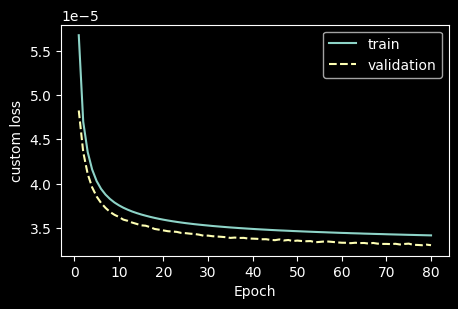

In [75]:
# learning curve
fig, ax0 = plt.subplots(1, 1, figsize=(5, 3))

ax0.plot(range(1, n_epochs + 1), np.array(train_epochs_losses), label='train')
ax0.plot(range(1, n_epochs + 1), np.array(val_epochs_losses), linestyle='dashed', label='validation')

ax0.set_ylabel(loss_func_name)
ax0.set_xlabel('Epoch')
# ax0.set_ylim([0.42 * 1e-5, 0.9 * 1e-5])

ax0.legend()

plt.show()

#### Losses parts

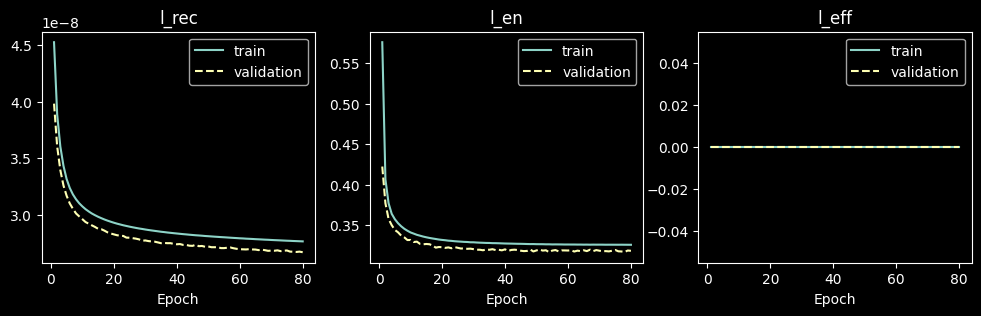

In [76]:
# learning curve
fig, axs = plt.subplots(1, 3, figsize=(12, 3))

for ax, key in zip(axs, losses_parts_names):
    ax.plot(range(1, n_epochs + 1), np.array(train_epochs_loss_parts[key]), label='train')
    ax.plot(range(1, n_epochs + 1), np.array(val_epochs_loss_parts[key]), linestyle='dashed', label='validation')

    ax.set_title(key)
    ax.set_xlabel('Epoch')
    ax.legend()

plt.show()

#### Trained masks (encoder)

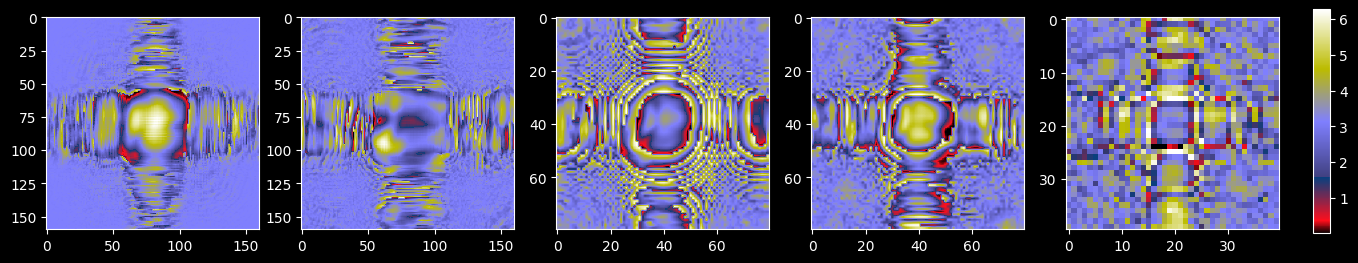

In [82]:
n_cols = NUM_ENCODER_LAYERS  # number of columns for DiffractiveLayer's masks visualization
n_rows = 1

# plot wavefronts phase
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3 + 2, n_rows * 3.2))
ind_diff_layer = 0

net_type = 'encoder'
cmap = 'gist_stern'  # 'gist_stern' 'rainbow'

net_to_plot = autoencoder_to_train.encoder if net_type == 'encoder' else autoencoder_to_train.decoder

for ind_layer, layer in enumerate(net_to_plot):
    if isinstance(layer, elements.DiffractiveLayer) or isinstance(layer, elements.SpatialLightModulator):  
        # plot masks for Diffractive layers
        if n_rows > 1:
            ax_this = axs[ind_diff_layer // n_cols][ind_diff_layer % n_cols]
        else:
            ax_this = axs[ind_diff_layer % n_cols]

        # ax_this.set_title(titles[ind_module])

        trained_mask = layer.mask.detach()
        
        phase_mask_this = ax_this.imshow(         
            trained_mask, cmap=cmap,
            # vmin=0, vmax=MAX_PHASE
        )
        ind_diff_layer += 1

        if APERTURES:  # select only a part within apertures!
            x_frame = (x_layer_nodes - DETECTOR_SIZE[1]) / 2
            y_frame = (y_layer_nodes - DETECTOR_SIZE[0]) / 2
            ax_this.axis([x_frame, x_layer_nodes - x_frame, y_layer_nodes - y_frame, y_frame])

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.01, 0.7])
plt.colorbar(phase_mask_this, cax=cbar_ax)

plt.show()

#### Saving results

In [78]:
# array with all losses
all_lasses_header = ','.join([
    'train_l_rec', 'train_l_en', 'train_l_eff', 'loss_train', 
    'val_l_rec', 'val_l_en', 'val_l_eff', 'loss_val',
])
all_losses_array = np.array(
    [
        train_epochs_loss_parts['l_rec'], train_epochs_loss_parts['l_en'], train_epochs_loss_parts['l_eff'], train_epochs_losses, 
        val_epochs_loss_parts['l_rec'], val_epochs_loss_parts['l_en'], val_epochs_loss_parts['l_eff'], val_epochs_losses
    ]
).T

In [79]:
# filepath to save the model
model_filepath = f'{RESULTS_FOLDER}/autoencoder_net.pth'
# filepath to save losses
losses_filepath = f'{RESULTS_FOLDER}/training_curves.csv'

#### Saving model weights and learning curves

In [80]:
# saving model
torch.save(autoencoder_to_train.state_dict(), model_filepath)

In [81]:
# saving losses
np.savetxt(
    losses_filepath, all_losses_array,
    delimiter=',', header=all_lasses_header, comments=""
)

## 4.4. Examples of encoding/decoding

### 4.4.1. Select a sample to encode/decode

In [108]:
n_test_examples = 5

random.seed(78)
test_examples_ids = random.sample(range(len(mnist_wf_test_ds)), n_test_examples)

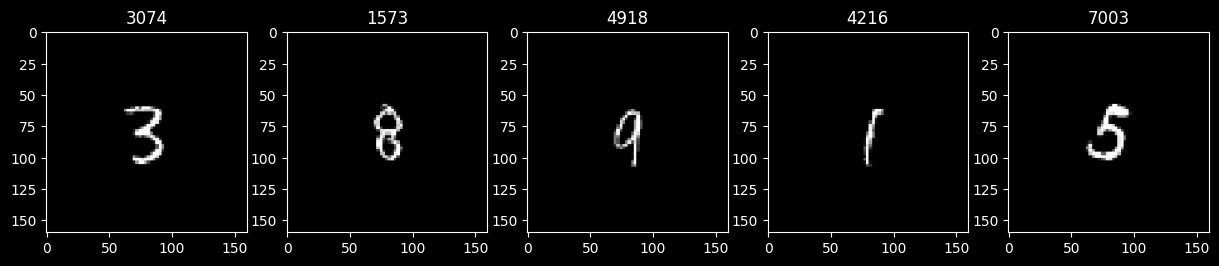

In [109]:
fig, axs = plt.subplots(1, n_test_examples, figsize=(n_test_examples * 3, 3))
cmap = 'grey'

for ax, ind_test in zip(axs, test_examples_ids):
    test_wavefront, test_target = mnist_wf_test_ds[ind_test]

    ax.set_title(f'{ind_test}')
    ax.imshow(test_wavefront.intensity, cmap=cmap)

    # ax.set_xticks([])
    # ax.set_yticks([])

plt.show()

### 4.4.2. Encode/decode an example

#### Function to encode and decode

In [93]:
def encode_and_decode(autoencoder, input_wf, use_encoder_aperture=False):
    # if use_encoder_aperture is True - apply strickt square aperture to encoded image
    # aperture is defined as REGION_MASK, that was used in loss!
    
    with torch.no_grad():
        # ENCODE
        encoded_image = autoencoder.encode(input_wf)
        if not PRESERVE_PHASE:
            encoded_image = encoded_image.abs() + 0j  # reset phases before decoding!
        if use_encoder_aperture:
            encoded_image = encoded_image * REGION_MASK  # apply aperture for encoded image
            
        # DECODE
        decoded_image = autoencoder.decode(encoded_image)
        if not PRESERVE_PHASE:
            decoded_image = decoded_image.abs() + 0j  # reset phases before decoding!

    return encoded_image, decoded_image

#### Plot all examples

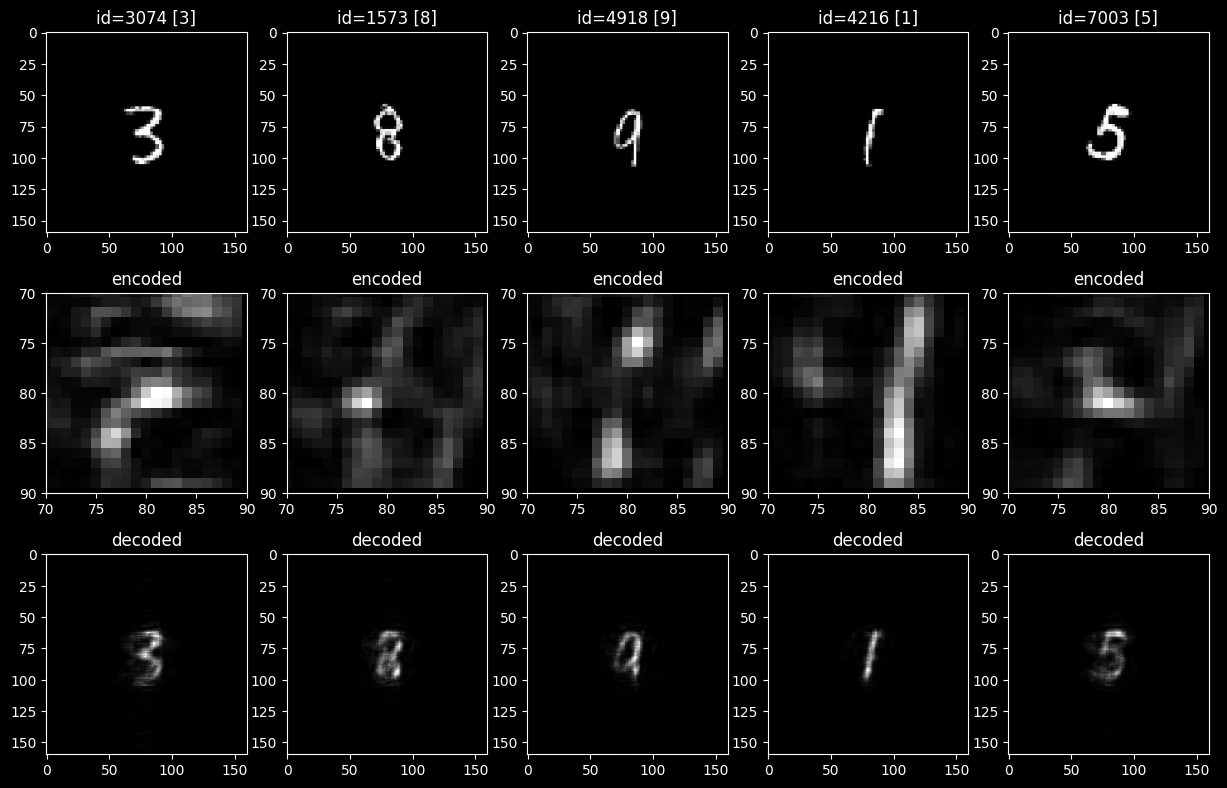

In [110]:
n_lines = 3  # image / encoded / decoded

fig, axs = plt.subplots(n_lines, n_test_examples, figsize=(n_test_examples * 3, n_lines * 3.2))

to_plot = 'amp'  # <--- chose what to plot
cmap = 'grey'  # choose colormaps
use_encoder_aperture = True

max_amp = 1  # upper limits for colorplots
max_phase = 2 * torch.pi

for ind_ex, ind_test in enumerate(test_examples_ids):
    ax_image, ax_encoded, ax_decoded = axs[0][ind_ex], axs[1][ind_ex], axs[2][ind_ex]
    
    test_wavefront, test_target = mnist_wf_test_ds[ind_test]

    ax_image.set_title(f'id={ind_test} [{test_target}]')
    if to_plot == 'amp':
        ax_image.imshow(
            test_wavefront.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_image.imshow(
            test_wavefront.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )

    encoded_this, decoded_this = encode_and_decode(
        autoencoder_to_train, test_wavefront, use_encoder_aperture
    )

    ax_encoded.set_title('encoded')
    if to_plot == 'amp':
        ax_encoded.imshow(
            encoded_this.intensity, cmap=cmap,
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_encoded.imshow(
            encoded_this.phase, cmap=cmap,
            # vmin=0, vmax=max_phase
        )
    if use_encoder_aperture:  # select only a part within apertures!
        x_frame = (x_layer_nodes - REGION_MASK_SIZE[1]) / 2
        y_frame = (y_layer_nodes - REGION_MASK_SIZE[0]) / 2
        ax_encoded.set_xlim([x_frame, x_layer_nodes - x_frame])
        ax_encoded.set_ylim([y_layer_nodes - y_frame, y_frame])

    ax_decoded.set_title('decoded')
    if to_plot == 'amp':
        ax_decoded.imshow(
            decoded_this.intensity, cmap=cmap, 
            # vmin=0, vmax=max_amp
        )
    if to_plot == 'phase':
        ax_decoded.imshow(
            decoded_this.phase, cmap=cmap, 
            # vmin=0, vmax=max_phase
        )

plt.show()